## Example 1: Spin-Bath model
### Introduction

The HEOM method solves the dynamics and steady state of a system and its environment, the latter of which is encoded in a set of auxiliary density matrices.

In this example we show the evolution of a single two-level system in contact with a single Bosonic environment.  The properties of the system are encoded in Hamiltonian, and a coupling operator which describes how it is coupled to the environment.

The Bosonic environment is implicitly assumed to obey a particular Hamiltonian (see paper), the parameters of which are encoded in the spectral density, and subsequently the free-bath correlation functions.

In the example below we show how to model the overdamped Drude-Lorentz Spectral Density, commonly used with the HEOM. We show how to do this the Matsubara, Pade and fitting decompositions, and compare their convergence.  

### Drude-Lorentz (overdamped) spectral density
The Drude-Lorentz spectral density is:

$$J_D(\omega)= \frac{2\omega\lambda\gamma}{{\gamma}^2 + \omega^2}$$

where $\lambda$ scales the coupling strength, and $\gamma$ is the cut-off frequency.  We use the convention,
\begin{equation*}
C(t) = \int_0^{\infty} d\omega \frac{J_D(\omega)}{\pi}[\coth(\beta\omega) \cos(\omega \tau) - i \sin(\omega \tau)]
\end{equation*}

With the HEOM we must use an exponential decomposition:

\begin{equation*}
C(t)=\sum_{k=0}^{k=\infty} c_k e^{-\nu_k t}
\end{equation*}

As an example, the Matsubara decomposition of the Drude-Lorentz spectral density is given by:

\begin{equation*}
    \nu_k = \begin{cases}
               \gamma               & k = 0\\
               {2 \pi k} / {\beta }  & k \geq 1\\
           \end{cases}
\end{equation*}

\begin{equation*}
    c_k = \begin{cases}
               \lambda \gamma (\cot(\beta \gamma / 2) - i)             & k = 0\\
               4 \lambda \gamma \nu_k / \{(nu_k^2 - \gamma^2)\beta \}    & k \geq 1\\
           \end{cases}
\end{equation*}

Note that in the above, and the following, we set $\hbar = k_\mathrm{B} = 1$.



Note that in the above, and the following, we set $\hbar = k_\mathrm{B} = 1$.



In [1]:
%pylab inline
from qutip import *

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:

#Here we import both python and c++ solvers to compare results and performance
from heom_fmotd import BosonicHEOMSolver
from heom_fmotd_py import BosonicHEOMSolver as BosonicHEOMSolverPy

In [4]:

def cot(x):
    return 1./np.tan(x)


In [5]:
# Defining the system Hamiltonian
eps = .5     # Energy of the 2-level system.
Del = 1.0    # Tunnelling term
Hsys = 0.5 * eps * sigmaz() + 0.5 * Del* sigmax()

In [6]:
# Initial state of the system.
rho0 = basis(2,0) * basis(2,0).dag()  

In [7]:
# System-bath coupling (Drude-Lorentz spectral density)
Q = sigmaz() # coupling operator

tlist = np.linspace(0, 50, 1000)

#Bath properties:
gamma = .5 # cut off frequency
lam = .1 # coupling strength
T = 0.5
beta = 1./T

#HEOM parameters
NC = 5 # cut off parameter for the bath




Text(0, 0.5, 'J')

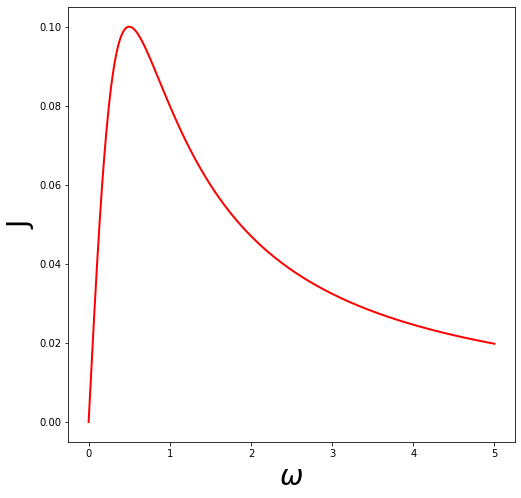

In [8]:


wlist = np.linspace(0, 5, 1000)
pref = 1.

J = [w * 2 * lam * gamma / ((gamma**2 + w**2)) for w in wlist]

# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
axes.plot(wlist, J, 'r', linewidth=2)
axes.set_xlabel(r'$\omega$', fontsize=28)
axes.set_ylabel(r'J', fontsize=28)



In [9]:
Nk = 2 # number of exponentials in approximation of the Matsubara approximation


def _calc_matsubara_params():
        """
        Calculate the Matsubara coefficents and frequencies
        Returns
        -------
        c, nu: both list(float)
        """
        c = []
        nu = []
        lam0 = lam
        gam = gamma
        hbar = 1
        beta = 1.0/T
        N_m =  Nk

        g = 2*np.pi / (beta)
        for k in range(N_m):
            if k == 0:
                nu.append(gam)
                c.append(lam0*gam*
                    (1.0/np.tan(gam*hbar*beta/2.0) - 1j) / hbar)
            else:
                g = 2*np.pi / (beta)
                nu.append(k*g)
                c.append(4*lam0*gam*nu[k] /
                      ((nu[k]**2 - gam**2)*beta*hbar**2))

    
        return c, nu

ctest,nutest=_calc_matsubara_params()



ckAR = [ lam * gamma * (cot(gamma / (2 * T)))]
ckAR.extend([(4 * lam * gamma * T *  2 * np.pi * k * T / (( 2 * np.pi * k * T)**2 - gamma**2)) for k in range(1,Nk+1)])

vkAR = [gamma]
vkAR.extend([2 * np.pi * k * T for k in range(1,Nk+1)])

ckAI = [lam * gamma * (-1.0)]

vkAI = [gamma]



In [12]:

tlist_corr = linspace(0,2,1000)

lmaxmats = 1500

def c(t,anamax):

    c_temp = (pref * lam * gamma * (-1.0j + cot(gamma / (2 * T))) * np.exp(-gamma * t))
    for k in range(1, anamax):
        vk = 2 * np.pi * k * T
        c_temp += ((pref * 4 * lam * gamma * T * vk / (vk**2 - gamma**2))  * np.exp(- vk * t) ) 
        
    
    return c_temp

# Reals parts
corrRana = [np.real(c(t,lmaxmats)) for t in tlist_corr]
# Imaginary parts
corrIana = [np.imag((pref * lam * gamma * (-1.0j + cot(gamma / (2 * T))) * np.exp(-gamma * t))) for t in tlist_corr]



Text(0, 0.5, 'C(t)')

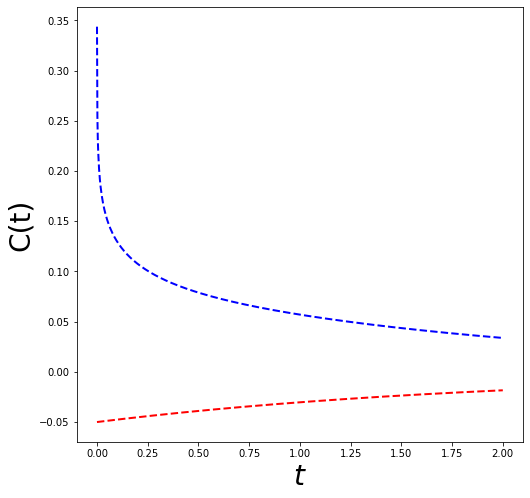

In [13]:


# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))

axes.plot(tlist_corr, corrRana, 'b--', linewidth=2)
axes.plot(tlist_corr, corrIana, 'r--', linewidth=2)
axes.set_xlabel(r'$t$', fontsize=28)
axes.set_ylabel(r'C(t)', fontsize=28)


In [14]:

NR = len(ckAR)
NI = len(ckAI)
Q2 = [Q for kk in range(NR+NI)]
# print(Q2)
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)
import time
start = time.time()
HEOMMats = BosonicHEOMSolver(Hsys, Q2, ckAR, ckAI, vkAR, vkAI, NC, options=options)
end = time.time()
print(end - start)


start = time.time()
resultMats = HEOMMats.run(rho0, tlist) #normal  115
end = time.time()
print("ODE solver time", end - start)

0.010622739791870117
ODE solver time 0.3244445323944092


In [15]:
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p=basis(2,0) * basis(2,0).dag()
P22p=basis(2,1) * basis(2,1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p=basis(2,0) * basis(2,1).dag()
# Calculate expectation values in the bases
P11exp = expect(resultMats.states, P11p)
P22exp = expect(resultMats.states, P22p)
P12exp = expect(resultMats.states, P12p)

## Ishizaki-Tanimura Terminator

The value of $Re[C(t=0)]$ diverges. We can treat that component as a delta-function distribution, and include it as Lindblad correction. This is sometimes known as the Ishizaki-Tanimura Terminator.

In more detail, given

\begin{equation*}
C(t)=\sum_{k=0}^{\infty} c_k e^{-\nu_k t}
\end{equation*}
since $\nu_k=\frac{2 \pi k}{\beta }$, if $1/\nu_k$ is much much smaller than other important time-scales, we can approximate,  $ e^{-\nu_k t} \approx \delta(t)/\nu_k$, and $C(t)=\sum_{k=N_k}^{\infty} \frac{c_k}{\nu_k} \delta(t)$

It is convenient to calculate the whole sum $C(t)=\sum_{k=0}^{\infty} \frac{c_k}{\nu_k} =  2 \lambda / (\beta \gamma) - i\lambda $, and subtract off the contribution from the finite number of Matsubara terms that are kept in the hierarchy, and treat the residual as a Lindblad.

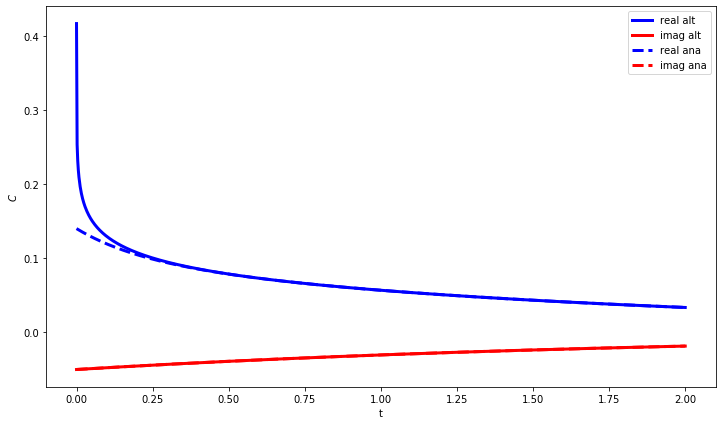

In [21]:
#This is clearer if we plot the correlation function with a large number of matsubara terms:  the real part is 
#slowly diverging at t=0

lmaxmats = 3
anamax = 15000

def c(t,anamax):

    c_temp = (pref * lam * gamma * (-1.0j + cot(gamma / (2 * T))) * np.exp(-gamma * t))
    for k in range(1, anamax):
        vk = 2 * np.pi * k * T
        c_temp += ((pref * 4 * lam * gamma * T * vk / (vk**2 - gamma**2))  * np.exp(- vk * t) ) 
        
    
    return c_temp

# Reals parts
corrRana = [np.real(c(t,lmaxmats)) for t in tlist_corr]
# Imaginary parts
corrIana = [np.imag((pref * lam * gamma * (-1.0j + cot(gamma / (2 * T))) * np.exp(-gamma * t))) for t in tlist_corr]



cppL = c( tlist_corr,anamax)

fig, ax1 = plt.subplots(figsize=(12, 7))
#print(gam_list)
ax1.plot( tlist_corr,real(cppL), color="b", linewidth=3, label= r"real alt")
ax1.plot( tlist_corr,imag(cppL), color="r", linewidth=3, label= r"imag alt")
ax1.plot( tlist_corr,corrRana, "b--", linewidth=3, label= r"real ana")
ax1.plot( tlist_corr,corrIana, "r--", linewidth=3, label= r"imag ana")


ax1.set_xlabel("t")
ax1.set_ylabel(r"$C$")
ax1.legend()

In [22]:
#do version with tanimura terminator

op = -2*spre(Q)*spost(Q.dag()) + spre(Q.dag()*Q) + spost(Q.dag()*Q)

approx_factr = ((2 * lam / (beta * gamma)) - 1j*lam) 

approx_factr -=  lam * gamma * (-1.0j + cot(gamma / (2 * T)))/gamma
for k in range(1,Nk+1):
    vk = 2 * np.pi * k * T
    #c_temp.append((pref * 4 * lam * gamma * T * vk / (vk**2 - gamma**2))  * np.exp(- vk * t) ) 
    approx_factr -= ((pref * 4 * lam * gamma * T * vk / (vk**2 - gamma**2))/ vk)
    #approx_factr -= (c[k] / nu[k])
L_bnd = -approx_factr*op

Ltot = -1.0j*(spre(Hsys)-spost(Hsys)) + L_bnd
Ltot = liouvillian(Hsys) + L_bnd

NR = len(ckAR)
NI = len(ckAI)
Q2 = [Q for kk in range(NR+NI)]
# print(Q2)
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)

HEOMMatsT = BosonicHEOMSolver(Ltot, Q2, ckAR, ckAI, vkAR, vkAI, NC, options=options)
# Initial state of the system.
rho0 = basis(2,0) * basis(2,0).dag()   
# Times to record state
#tlist = np.linspace(0, 40, 600)

resultMatsT = HEOMMatsT.run(rho0, tlist)
# print(resultMatsT)


In [23]:
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p=basis(2,0) * basis(2,0).dag()
P22p=basis(2,1) * basis(2,1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p=basis(2,0) * basis(2,1).dag()
# Calculate expectation values in the bases
P11expT = expect(resultMatsT.states, P11p)
P22expT = expect(resultMatsT.states, P22p)
P12expT = expect(resultMatsT.states, P12p)

In [24]:
DL = " 2*pi* 2.0 * {lam} / (pi * {gamma} * {beta})  if (w==0) else 2*pi*(2.0*{lam}*{gamma} *w /(pi*(w**2+{gamma}**2))) * ((1/(exp((w) * {beta})-1))+1)".format(gamma=gamma, beta = beta, lam = lam)

optionsODE = Options(nsteps=15000, store_states=True,rtol=1e-12,atol=1e-12)
outputBR  =  brmesolve(Hsys, rho0, tlist, a_ops=[[sigmaz(),DL]], options = optionsODE)


# Calculate expectation values in the bases
P11BR = expect(outputBR.states, P11p)
P22BR = expect(outputBR.states, P22p)
P12BR = expect(outputBR.states, P12p)

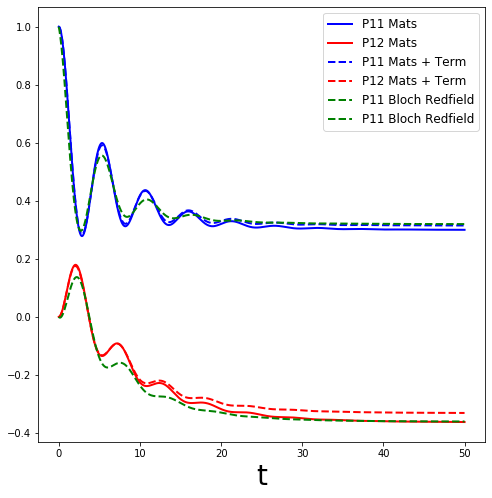

In [25]:

# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
#axes.plot(tlist, np.real(P11exp)+ np.real(P22exp), 'b', linewidth=2, label="P11")
axes.plot(tlist, np.real(P11exp), 'b', linewidth=2, label="P11 Mats")
axes.plot(tlist, np.real(P12exp), 'r', linewidth=2, label="P12 Mats")
axes.plot(tlist, np.real(P11expT), 'b--', linewidth=2, label="P11 Mats + Term")
axes.plot(tlist, np.real(P12expT), 'r--', linewidth=2, label="P12 Mats + Term")
axes.plot(tlist, np.real(P11BR), 'g--', linewidth=2, label="P11 Bloch Redfield")
axes.plot(tlist, np.real(P12BR), 'g--', linewidth=2, label="P11 Bloch Redfield")
axes.set_xlabel(r't', fontsize=28)
axes.legend(loc=0, fontsize=12)

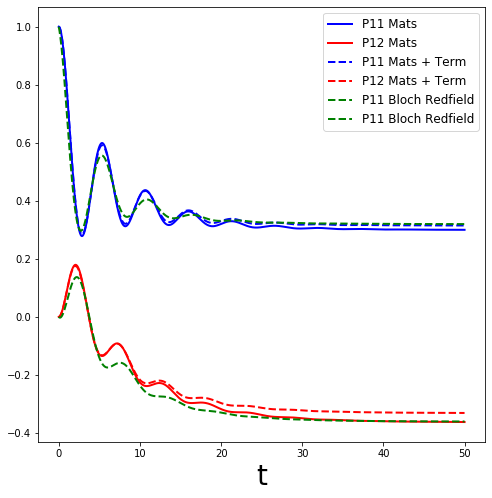

In [21]:

# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
#axes.plot(tlist, np.real(P11exp)+ np.real(P22exp), 'b', linewidth=2, label="P11")
axes.plot(tlist, np.real(P11exp), 'b', linewidth=2, label="P11 Mats")
axes.plot(tlist, np.real(P12exp), 'r', linewidth=2, label="P12 Mats")
axes.plot(tlist, np.real(P11expT), 'b--', linewidth=2, label="P11 Mats + Term")
axes.plot(tlist, np.real(P12expT), 'r--', linewidth=2, label="P12 Mats + Term")
axes.plot(tlist, np.real(P11BR), 'g--', linewidth=2, label="P11 Bloch Redfield")
axes.plot(tlist, np.real(P12BR), 'g--', linewidth=2, label="P11 Bloch Redfield")
axes.set_xlabel(r't', fontsize=28)
axes.legend(loc=0, fontsize=12)

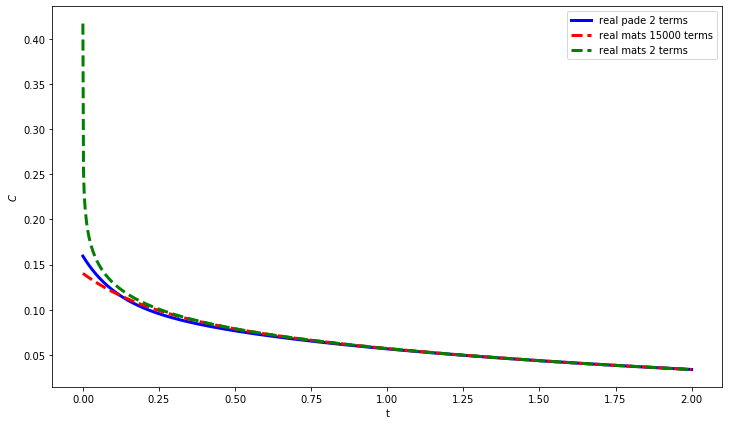

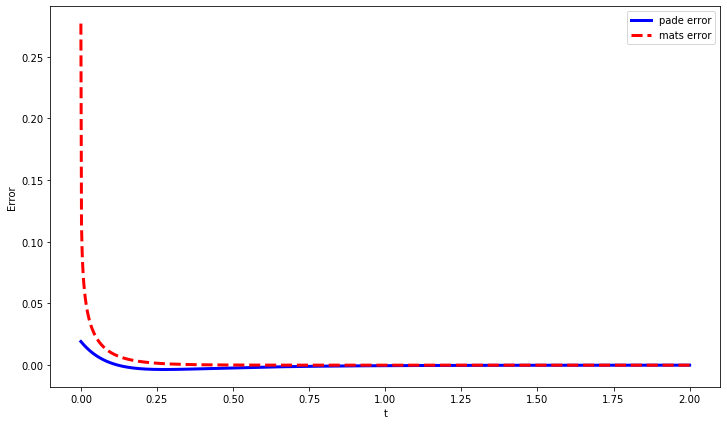

In [27]:
#We can compare the Matsubara result to the faster-converging Pade decomposition


lmax = 2




def deltafun(j,k):
    if j==k: 
        return 1.
    else:
        return 0.




Alpha =np.zeros((2*lmax,2*lmax))
for j in range(2*lmax):
    for k in range(2*lmax):
        #Alpha[j][k] = (deltafun(j,k+1)+deltafun(j,k-1))/sqrt((2*(j+1)-1)*(2*(k+1)-1)) #fermi
        Alpha[j][k] = (deltafun(j,k+1)+deltafun(j,k-1))/sqrt((2*(j+1)+1)*(2*(k+1)+1)) #bose
        
eigvalsA=eigvalsh(Alpha)  

eps = []
for val in  eigvalsA[0:lmax]:
    #print(-2/val)
    eps.append(-2/val)
    

AlphaP =np.zeros((2*lmax-1,2*lmax-1))
for j in range(2*lmax-1):
    for k in range(2*lmax-1):
        #AlphaP[j][k] = (deltafun(j,k+1)+deltafun(j,k-1))/sqrt((2*(j+1)+1)*(2*(k+1)+1)) #fermi
        
        AlphaP[j][k] = (deltafun(j,k+1)+deltafun(j,k-1))/sqrt((2*(j+1)+3)*(2*(k+1)+3)) #Bose: This is +3 because +1 (bose) + 2*(+1)(from bm+1)
        
eigvalsAP=eigvalsh(AlphaP)    


chi = []
for val in  eigvalsAP[0:lmax-1]:
    
    chi.append(-2/val)

    
eta_list = []
prefactor = 0.5*lmax*(2*(lmax + 1) - 1)

for j in range(lmax):
    term = prefactor
    for k1 in range(lmax - 1):
        term *= (chi[k1]**2 - eps[j]**2)/(eps[k1]**2 - eps[j]**2 + deltafun(j,k1))        
    
    for k2 in range(lmax-1,lmax):
        term /= (eps[k2]**2 - eps[j]**2 + deltafun(j,k2))
        
        
    eta_list.append(term)


kappa = [0]+eta_list
epsilon = [0]+eps



beta = 1/T

def f_approx(x):
    f = 0.5
    for l in range(1,lmax+1):
        f= f - 2*kappa[l]*x/(x**2+epsilon[l]**2)
    return f

def f(x):
    kB=1.
    return 1/(1-exp(-x)) #this is n(w)+1 (for bosons)


def C(tlist):
    eta_list = []
    gamma_list  =[]
    
    eta_0 =lam*gamma*(1.0/np.tan(gamma*beta/2.0) - 1.0j)
    gamma_0 = gamma
    eta_list.append(eta_0)
    gamma_list.append(gamma_0)
    if lmax>0:
        for l in range(1,lmax+1):
            eta_list.append((kappa[l]/beta)*4*lam*gamma*(epsilon[l]/beta)/((epsilon[l]**2/beta**2)-gamma**2))
            gamma_list.append(epsilon[l]/beta)
            
     
    c_tot = []
    for t in tlist:
        c_tot.append(sum([eta_list[l]*exp(-gamma_list[l]*t) for l in range(lmax+1)]))
    return c_tot, eta_list, gamma_list


cppLP,etapLP,gampLP = C( tlist_corr)


fig, ax1 = plt.subplots(figsize=(12, 7))
#print(gam_list)
ax1.plot( tlist_corr,real(cppLP), color="b", linewidth=3, label= r"real pade 2 terms")
#ax1.plot(tlist,imag(cppL), color="r", linewidth=3, label= r"imag alt")
ax1.plot( tlist_corr,corrRana, "r--", linewidth=3, label= r"real mats 15000 terms")
ax1.plot( tlist_corr,real(cppL), "g--", linewidth=3, label= r"real mats 2 terms")
#ax1.plot(tlist,corrIana, "r--", linewidth=3, label= r"imag ana")



ax1.set_xlabel("t")
ax1.set_ylabel(r"$C$")
ax1.legend()


fig, ax1 = plt.subplots(figsize=(12, 7))
#print(gam_list)
#ax1.plot(tlist,real(cppL), color="b", linewidth=3, label= r"real alt")
#ax1.plot(tlist,imag(cppL), color="r", linewidth=3, label= r"imag alt")
#ax1.plot(tlist,corrRana, "b--", linewidth=3, label= r"real ana")
#ax1.plot(tlist,corrIana, "r--", linewidth=3, label= r"imag ana")

ax1.plot( tlist_corr,real(cppLP)-corrRana, color="b", linewidth=3, label= r"pade error")
ax1.plot( tlist_corr,real(cppL)-corrRana,"r--", linewidth=3, label= r"mats error")
#ax1.plot(tlist,real(cppL)-corrRana, color="b", linewidth=3, label= r"mats error")

ax1.set_xlabel("t")
ax1.set_ylabel(r"Error")
ax1.legend()


In [28]:

ckAR = [real(eta) +0j for eta in etapLP]
ckAI = [imag(etapLP[0]) + 0j]
vkAR = [gam +0j for gam in gampLP]
vkAI = [gampLP[0] + 0j]

In [29]:


NR = len(ckAR)
NI = len(ckAI)
Q2 = [Q for kk in range(NR+NI)]
print(Q2)
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)

HEOMPade = BosonicHEOMSolver(Hsys, Q2, ckAR, ckAI, vkAR, vkAI, NC, options=options)

# Initial state of the system.
rho0 = basis(2,0) * basis(2,0).dag()   
# Times to record state
#tlist = np.linspace(0, 40, 600)

resultPade = HEOMPade.run(rho0, tlist)

[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]]


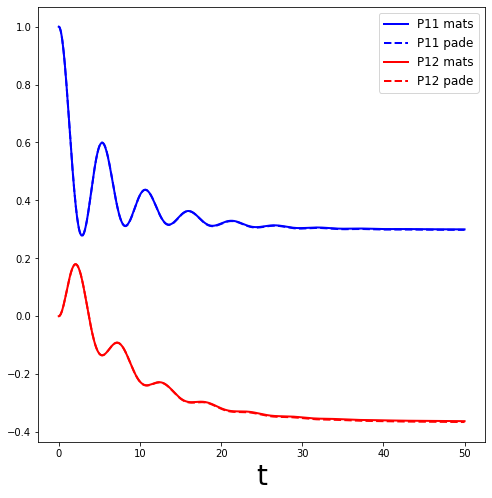

In [30]:

# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p=basis(2,0) * basis(2,0).dag()
P22p=basis(2,1) * basis(2,1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p=basis(2,0) * basis(2,1).dag()
# Calculate expectation values in the bases
P11expP = expect(resultPade.states, P11p)
P22expP = expect(resultPade.states, P22p)
P12expP = expect(resultPade.states, P12p)

# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
#axes.plot(tlist, np.real(P11exp)+ np.real(P22exp), 'b', linewidth=2, label="P11")
axes.plot(tlist, np.real(P11exp), 'b', linewidth=2, label="P11 mats")
axes.plot(tlist, np.real(P11expP), 'b--', linewidth=2, label="P11 pade")
axes.plot(tlist, np.real(P12exp), 'r', linewidth=2, label="P12 mats")
axes.plot(tlist, np.real(P12expP), 'r--', linewidth=2, label="P12 pade")
axes.set_xlabel(r't', fontsize=28)
axes.legend(loc=0, fontsize=12)

### Next we do fitting of correlation, and compare to Mats and Pade


In [31]:
#tlist2= linspace(0,600,100)
tlist2= linspace(0,2,10000)
#tlist2 = tlist

lmaxmats = 15000

def c(t,anamax):

    c_temp = (pref * lam * gamma * (-1.0j + cot(gamma / (2 * T))) * np.exp(-gamma * t))
    for k in range(1, anamax):
        vk = 2 * np.pi * k * T
        c_temp += ((pref * 4 * lam * gamma * T * vk / (vk**2 - gamma**2))  * np.exp(- vk * t) ) 
        
    
    return c_temp

# Reals parts
corrRana = [np.real(c(t,lmaxmats)) for t in tlist2]
# Imaginary parts
corrIana = [np.imag((pref * lam * gamma * (-1.0j + cot(gamma / (2 * T))) * np.exp(-gamma * t))) for t in tlist2]




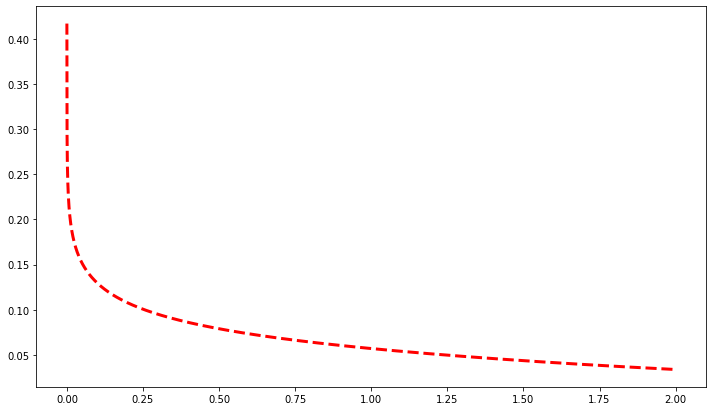

In [32]:

fig, ax1 = plt.subplots(figsize=(12, 7))
ax1.plot( tlist2,corrRana, "r--", linewidth=3, label= r"real mats 15000 terms")

1
2
3
4


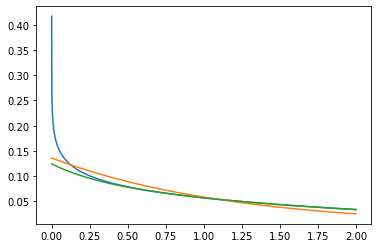

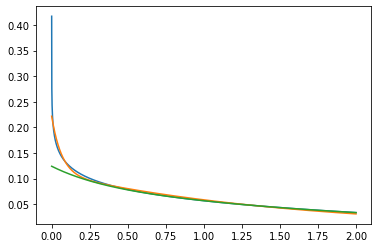

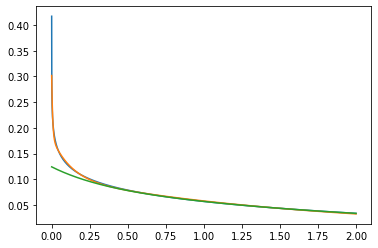

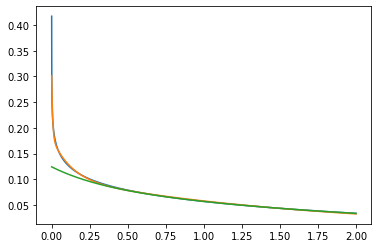

1


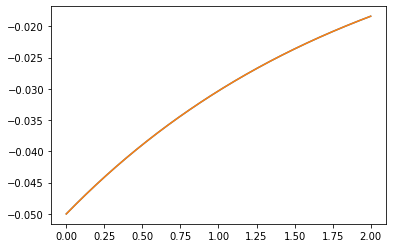

In [33]:


from scipy.optimize import curve_fit
def wrapper_fit_func(x, N, *args):
    a, b = list(args[0][:N]), list(args[0][N:2*N])
    # print("debug")
    return fit_func(x, a, b, N)

# actual fitting function
def fit_func(x, a, b, N):
    tot = 0
    for i in range(N):
        # print(i)
        tot += a[i]*np.exp(b[i]*x)
    return tot


def fitter(ans, tlist, k):
    # the actual computing of fit
    popt = []
    pcov = [] 
    # tries to fit for k exponents
    for i in range(k):
        params_0 = [0]*(2*(i+1))
        upper_a = abs(max(ans, key = abs))*10
        #sets initial guess
        guess = []
        aguess = [ans[0]]*(i+1)#[max(ans)]*(i+1)
        bguess = [0]*(i+1)
        guess.extend(aguess)
        guess.extend(bguess)
        # sets bounds
        b_lower = []
        alower = [-upper_a]*(i+1)
        blower = [-np.inf]*(i+1)
        b_lower.extend(alower)
        b_lower.extend(blower)
        # sets higher bound
        b_higher = []
        ahigher = [upper_a]*(i+1)
        bhigher = [0]*(i+1)
        b_higher.extend(ahigher)
        b_higher.extend(bhigher)
        param_bounds = (b_lower, b_higher)
        p1, p2 = curve_fit(lambda x, *params_0: wrapper_fit_func(x, i+1, \
            params_0), tlist, ans, p0=guess, sigma=[0.01 for t in tlist2], bounds = param_bounds,maxfev = 1e8)
        popt.append(p1)
        pcov.append(p2)
        print(i+1)
    return popt
# print(popt)

# function that evaluates values with fitted params at
# given inputs
def checker(tlist, vals):
    y = []
    for i in tlist:
        # print(i)
        y.append(wrapper_fit_func(i, int(len(vals)/2), vals))
    return y


k = 4
popt1 = fitter(corrRana, tlist2, k)


corrRMats = [np.real(c(t,Nk)) for t in tlist2]

for i in range(k):
    y = checker(tlist2, popt1[i])
    plt.plot(tlist2, corrRana, tlist2, y, tlist2, corrRMats)
    
    plt.show()

k1 = 1
popt2 = fitter(corrIana, tlist2, k1)
for i in range(k1):
    y = checker(tlist2, popt2[i])
    plt.plot(tlist2, corrIana, tlist2, y)
    plt.show()  


In [34]:
ckAR1 = list(popt1[k-1])[:len(list(popt1[k-1]))//2]
ckAR = [x+0j for x in ckAR1]
ckAI1 = list(popt2[k1-1])[:len(list(popt2[k1-1]))//2]

ckAI = [x+0j for x in ckAI1]
# vkAR, vkAI
vkAR1 = list(popt1[k-1])[len(list(popt1[k-1]))//2:]
vkAR = [-x+0j for x in vkAR1]
vkAI1 = list(popt2[k1-1])[len(list(popt2[k1-1]))//2:]
vkAI = [-x+0j for x in vkAI1]



In [35]:
#overwrite imaginary fit with analytical value (not much reason to use the fit for this)

ckAI = [pref * lam * gamma * (-1.0) + 0.j]

vkAI = [gamma+0.j]

print(ckAI)
print(vkAI)

[(-0.05+0j)]
[(0.5+0j)]


In [36]:

NC = 8

NR = len(ckAR)
NI = len(ckAI)
Q2 = [Q for kk in range(NR+NI)]
print(Q2)
options = Options(nsteps=1500, store_states=True, rtol=1e-12, atol=1e-12, method="bdf") 
#BDF because we have a slightly stiff problem

HEOMFit = BosonicHEOMSolver(Hsys, Q2, ckAR, ckAI, vkAR, vkAI, NC, options=options)


[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]]


In [37]:


# Initial state of the system.
rho0 = basis(2,0) * basis(2,0).dag()   
# Times to record state
#tlist = np.linspace(0, 40, 600)

start = time.time()
resultFit = HEOMFit.run(rho0, tlist)

end = time.time()
print("ODE solver time", end - start)

ODE solver time 33.63008260726929


In [38]:
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p=basis(2,0) * basis(2,0).dag()
P22p=basis(2,1) * basis(2,1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p=basis(2,0) * basis(2,1).dag()
# Calculate expectation values in the bases
P11expF = expect(resultFit.states, P11p)
P22expF = expect(resultFit.states, P22p)
P12expF = expect(resultFit.states, P12p)


In [130]:
#lmaxmats = 100000


#do version with tanimura terminator

op = -2*spre(Q)*spost(Q.dag()) + spre(Q.dag()*Q) + spost(Q.dag()*Q)

approx_factr = ((2 * lam / (beta * gamma)) - 1j*lam) 

approx_factr -=  lam * gamma * (-1.0j + cot(gamma / (2 * T)))/gamma

for k in range(1,lmaxmats):
    vk = 2 * np.pi * k * T
    #c_temp.append((pref * 4 * lam * gamma * T * vk / (vk**2 - gamma**2))  * np.exp(- vk * t) ) 
    approx_factr -= ((pref * 4 * lam * gamma * T * vk / (vk**2 - gamma**2))/ vk)
    #approx_factr -= (c[k] / nu[k])
    

L_bnd = -approx_factr*op

Ltot = -1.0j*(spre(Hsys)-spost(Hsys)) + L_bnd
#Ltot = liouvillian(Hsys) + L_bnd

NR = len(ckAR)
NI = len(ckAI)
Q2 = [Q for kk in range(NR+NI)]
print(Q2)
options = Options(nsteps=1500, store_states=True, rtol=1e-12, atol=1e-12, method="bdf") 


NC= 10
HEOMFitT = BosonicHEOMSolver(Ltot, Q2, ckAR, ckAI, vkAR, vkAI, NC, options=options)

# Initial state of the system.
rho0 = basis(2,0) * basis(2,0).dag()   
# Times to record state
#tlist = np.linspace(0, 40, 600)



resultFitT  = HEOMFitT.run(rho0, tlist)




(6.754970739519044e-07+0j)
(6.754970739519044e-07+0j)
[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]]


KeyboardInterrupt: 

In [ ]:


resultFitT  = HEOMFitT.run(rho0, tlist)


In [ ]:
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p=basis(2,0) * basis(2,0).dag()
P22p=basis(2,1) * basis(2,1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p=basis(2,0) * basis(2,1).dag()
# Calculate expectation values in the bases
P11expFT   = expect(resultFitT.states, P11p)
P22expFT   = expect(resultFitT.states, P22p)
P12expFT   = expect(resultFitT.states, P12p)

In [131]:
print(Hsys.eigenstates())
energies, states = Hsys.eigenstates()

(array([-0.55901699,  0.55901699]), array([Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[ 0.52573111]
 [-0.85065081]],
       Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.85065081]
 [-0.52573111]]], dtype=object))


In [132]:
print(Hsys.eigenstates())
energies, states = Hsys.eigenstates()
rhoss = (states[0]*states[0].dag()*exp(-beta*energies[0]) + states[1]*states[1].dag()*exp(-beta*energies[1]))
rhoss = rhoss/rhoss.norm()

P12 = expect(rhoss,P12p)
P11 = expect(rhoss,P11p)

(array([-0.55901699,  0.55901699]), array([Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[ 0.52573111]
 [-0.85065081]],
       Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.85065081]
 [-0.52573111]]], dtype=object))


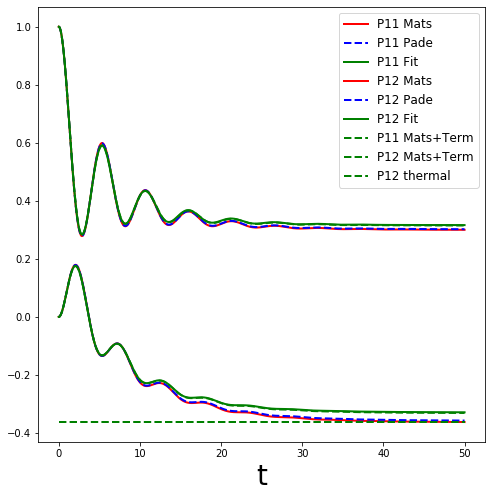

In [158]:
#big gamma
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate

# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
#axes.plot(tlist, np.real(P11exp)+ np.real(P22exp), 'b', linewidth=2, label="P11")
axes.plot(tlist, np.real(P11exp), 'r', linewidth=2, label="P11 Mats")
axes.plot(tlist, np.real(P11expP), 'b--', linewidth=2, label="P11 Pade")
axes.plot(tlist, np.real(P11expF), 'g', linewidth=2, label="P11 Fit")
#axes.plot(tlist, np.real(P11expFT), 'y--', linewidth=2, label="P11 Fit+tanimura")

axes.plot(tlist, np.real(P12exp), 'r', linewidth=2, label="P12 Mats")
axes.plot(tlist, np.real(P12expP), 'b--', linewidth=2, label="P12 Pade")
axes.plot(tlist, np.real(P12expF), 'g', linewidth=2, label="P12 Fit")
#axes.plot(tlist, np.real(P12expFT), 'y--', linewidth=2, label="P12 Fit + term")

axes.plot(tlist, np.real(P11expT), 'g--', linewidth=2, label="P11 Mats+Term")
axes.plot(tlist, np.real(P12expT), 'g--', linewidth=2, label="P12 Mats+Term")

axes.plot(tlist, [np.real(P12) for t in tlist], 'g--', linewidth=2, label="P12 thermal")

#axes.plot(tlist, [np.real(P11RC) for t in tlist], 'g--', linewidth=2, label="P12 thermal")

axes.set_xlabel(r't', fontsize=28)
axes.legend(loc=0, fontsize=12)



In [39]:
dot_energy, dot_state = Hsys.eigenstates()
deltaE = dot_energy[1] - dot_energy[0]

gamma2 = deltaE / (2 * np.pi * gamma)
wa = 2 * np.pi * gamma2 *   gamma # reaction coordinate frequency
g = np.sqrt(np.pi * wa * lam / 2.0)  # reaction coordinate coupling
g = np.sqrt(np.pi * wa * lam / 4.0)  # reaction coordinate coupling Factor over 2 because of diff in J(w) (I have 2 lam now)
#nb = (1 / (np.exp(wa/w_th) - 1))

NRC = 10

Hsys_exp = tensor(qeye(NRC), Hsys)
Q_exp = tensor(qeye(NRC), Q)
a = tensor(destroy(NRC), qeye(2))

H0 = wa * a.dag() * a + Hsys_exp
# interaction
H1 = (g * (a.dag() + a) * Q_exp)

H = H0 + H1

#print(H.eigenstates())
energies, states = H.eigenstates()
rhoss = 0*states[0]*states[0].dag()
for kk, energ in enumerate(energies):
    rhoss += (states[kk]*states[kk].dag()*exp(-beta*energies[kk])) 

#rhoss = (states[0]*states[0].dag()*exp(-beta*energies[0]) + states[1]*states[1].dag()*exp(-beta*energies[1]))

rhoss = rhoss/rhoss.norm()

P12RC = tensor(qeye(NRC), basis(2,0) * basis(2,1).dag())

P12RC = expect(rhoss,P12RC)


P11RC = tensor(qeye(NRC), basis(2,0) * basis(2,0).dag())

P11RC = expect(rhoss,P11RC)

In [40]:
matplotlib.rcParams['figure.figsize'] = (7, 5)
matplotlib.rcParams['axes.titlesize'] = 25
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['lines.markersize'] = 5
matplotlib.rcParams['font.family'] = 'STIXGeneral' 
matplotlib.rcParams['mathtext.fontset'] =  'stix'

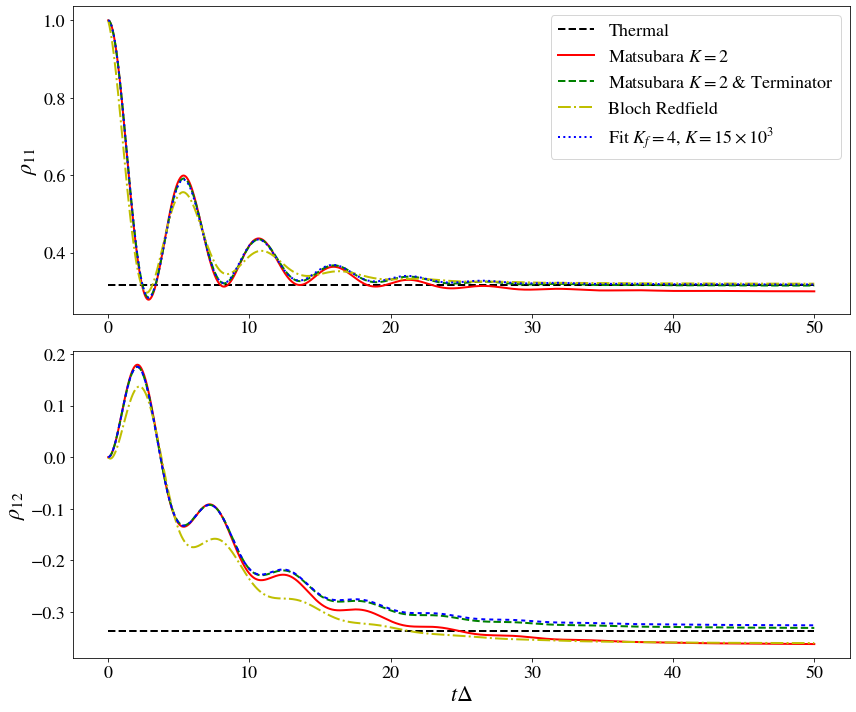

In [41]:
#matplotlib.rcParams.update({'font.size': 18, 'text.usetex': True})
#matplotlib.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix','text.usetex': False})

# Plot the results
fig, axes = plt.subplots(2, 1, sharex=False, figsize=(12,10))

axes[0].plot(tlist, [np.real(P11RC) for t in tlist], 'black', ls='--',linewidth=2, label="Thermal")
axes[0].plot(tlist, np.real(P11exp), 'r', linewidth=2, label="Matsubara $K=2$")
axes[0].plot(tlist, np.real(P11expT), 'g--', linewidth=2, label="Matsubara $K=2$ & Terminator")
axes[0].plot(tlist, np.real(P11BR), 'y-.', linewidth=2, label="Bloch Redfield")
axes[0].plot(tlist, np.real(P11expF ), 'b:', linewidth=2, label=r"Fit $K_f = 4$, $K=15\times 10^3$")
#axes[0].plot(tlist, np.real(P11expF1e6 ),  color='purple', dashes=[6, 2], linewidth=2, label=r"Fit $K_f = 4$, $K=1\times 10^5$ & terminator")


axes[0].locator_params(axis='y', nbins=6)
axes[0].locator_params(axis='x', nbins=6)


#axes[0].set_xlim(0,200)
axes[0].set_ylabel(r"$\rho_{11}$")#, fontsize=20)
axes[0].legend(loc=0)
#axes[0].Rectangle(




axes[1].plot(tlist, [np.real(P12RC) for t in tlist], 'black', ls='--', linewidth=2, label="Thermal")
axes[1].plot(tlist, np.real(P12exp), 'r', linewidth=2, label="Matsubara $K=2$")
axes[1].plot(tlist, np.real(P12expT), 'g--', linewidth=2, label="Matsubara $K=2$ & Terminator")
axes[1].plot(tlist, np.real(P12BR), 'y-.', linewidth=2, label="Bloch Redfield")
axes[1].plot(tlist, np.real(P12expF ), 'b', dashes=[2,2], linewidth=2, label=r"Fit $K_f = 4$, $K=15\times 10^3$")




axes[1].locator_params(axis='y', nbins=6)
axes[1].locator_params(axis='x', nbins=6)



#axes[1].set_xlim(200,600)
axes[1].set_xlabel(r'$t \Delta$')#, fontsize=20)
axes[1].set_ylabel(r'$\rho_{12}$')#, fontsize=20)
#axes[1].legend(loc=0)

fig.tight_layout()
fig.savefig("fig1.pdf")

In [176]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.5.0.dev0
Numpy,1.18.1
SciPy,1.4.1
matplotlib,3.1.2
Cython,0.29.14
Number of CPUs,4
BLAS Info,INTEL MKL
IPython,7.11.1
Python,"3.7.3 (default, Mar 27 2019, 22:11:17) [GCC 7.3.0]"
OS,posix [linux]
